In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pandas as pd
from typing import Final, Sequence, Tuple, Union
from pathlib import Path

from av2.datasets.motion_forecasting import scenario_serialization
from av2.map.map_api import ArgoverseStaticMap

import git
repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir

In [3]:
SAVE_DIR = os.path.join(BASE_DIR,"preprocess","av2_scenario_examples")

# scaled to [0,1] for matplotlib.
PURPLE_RGB: Final[Tuple[int, int, int]] = (201, 71, 245)
PURPLE_RGB_MPL: Final[Tuple[float, float, float]] = (PURPLE_RGB[0] / 255, PURPLE_RGB[1] / 255, PURPLE_RGB[2] / 255)

DARK_GRAY_RGB: Final[Tuple[int, int, int]] = (40, 39, 38)
DARK_GRAY_RGB_MPL: Final[Tuple[float, float, float]] = (
    DARK_GRAY_RGB[0] / 255,
    DARK_GRAY_RGB[1] / 255,
    DARK_GRAY_RGB[2] / 255,
)

OVERLAID_MAPS_ALPHA: Final[float] = 0.1

In [6]:
BASE_DIR

'/home/robesafe/CGHFormer'

In [9]:
# id_ = "0006ca28-fcbb-4ae2-9d9e-951fa3b41c1c"
id_ = "0000b0f9-99f9-4a1f-a231-5be9e4c523f7"

scenario_path_filename = os.path.join(BASE_DIR,"dataset/argoverse2/train",f"{id_}/scenario_{id_}.parquet")
scenario_path = Path(scenario_path_filename)

In [10]:
# class ArgoverseScenario:
#     """Bundles all data associated with an Argoverse scenario.

#     Attributes:
#         scenario_id: Unique ID associated with this scenario.
#         timestamps_ns: All timestamps associated with this scenario.
#         tracks: All tracks associated with this scenario.
#         focal_track_id: The track ID associated with the focal agent of the scenario.
#         city_name: The name of the city associated with this scenario.
#         map_id: The map ID associated with the scenario (used for internal bookkeeping).
#         slice_id: ID of the slice used to generate the scenario (used for internal bookkeeping).
#     """

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
df = pd.read_parquet(scenario_path)

In [11]:
target_rows = df.loc[df["track_id"] == scenario.focal_track_id]
OBS_LEN = 50
PRED_LEN = 60
last_obs_x, last_obs_y = target_rows["position_x"].iloc[OBS_LEN], target_rows["position_y"].iloc[OBS_LEN]
last_obs_x, last_obs_y

(42.23505699062542, -340.5033587553137)

In [14]:
# class ArgoverseStaticMap:
#     """API to interact with a local map for a single log (within a single city).

#     Nodes in the lane graph are lane segments. Edges in the lane graph provided the lane segment connectivity, via
#     left and right neighbors and successors.

#     Lane segments are parameterized by 3d waypoints representing their left and right boundaries.
#         Note: predecessors are implicit and available by reversing the directed graph dictated by successors.

#     Args:
#         log_id: unique identifier for log/scenario.
#         vector_drivable_areas: drivable area polygons. Each polygon is represented by a Nx3 array of its vertices.
#             Note: the first and last polygon vertex are identical (i.e. the first index is repeated).
#         vector_lane_segments: lane segments that are local to this log/scenario. Consists of a mapping from
#             lane segment ID to vector lane segment object, parameterized in 3d.
#         vector_pedestrian_crossings: all pedestrian crossings (i.e. crosswalks) that are local to this log/scenario.
#             Note: the lookup index is simply a list, rather than a dictionary-based mapping, since pedestrian crossings
#             are not part of a larger graph.
#         raster_drivable_area_layer: 2d raster representation of drivable area segmentation.
#         raster_roi_layer: 2d raster representation of region of interest segmentation.
#         raster_ground_height_layer: not provided for Motion Forecasting-specific scenarios/logs.
#     """

scenario_id = scenario_path.stem.split("_")[-1]
static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"
static_map = ArgoverseStaticMap.from_json(static_map_path)

In [12]:
import click
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

import av2.geometry.polyline_utils as polyline_utils
import av2.geometry.interpolate as interpolate
import av2.rendering.vector as vector_plotting_utils
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from av2.map.lane_segment import LaneSegment
from av2.map.map_api import ArgoverseStaticMap
from av2.utils.typing import NDArrayFloat, NDArrayInt

def plot_lane_segments(
    ax: Axes, lane_segments: Sequence[LaneSegment], lane_color: Tuple[float, float, float] = DARK_GRAY_RGB_MPL
) -> None:
    """Plot lane segments onto a Matplotlib canvas, according to their lane marking boundary type/color.

    Note: we use an approximation for SOLID_DASHED and other mixed pattern/color marking types.

    Args:
        ax: matplotlib figure to use as drawing canvas.
        lane_segments: lane segment objects. The lane markings along their boundaries will be rendered.
        lane_color: Color of the lane.
    """
    for ls in lane_segments:
        pts_city = ls.polygon_boundary
        ALPHA = 1.0  # 0.1
        vector_plotting_utils.plot_polygon_patch_mpl(
            polygon_pts=pts_city, ax=ax, color=lane_color, alpha=ALPHA, zorder=1
        )

        mark_color: str = ""
        linestyle: Union[str, Tuple[int, Tuple[int, int]]] = ""
        for bound_type, bound_city in zip(
            [ls.left_mark_type, ls.right_mark_type], [ls.left_lane_boundary, ls.right_lane_boundary]
        ):
            if "YELLOW" in bound_type:
                mark_color = "y"
            elif "WHITE" in bound_type:
                mark_color = "w"
            elif "BLUE" in bound_type:
                mark_color = "b"
            else:
                mark_color = "grey"

            LOOSELY_DASHED = (0, (5, 10))

            if "DASHED" in bound_type:
                linestyle = LOOSELY_DASHED
            else:
                linestyle = "solid"

            if "DOUBLE" in bound_type:
                left, right = polyline_utils.get_double_polylines(
                    polyline=bound_city.xyz[:, :2], width_scaling_factor=0.1
                )
                ax.plot(left[:, 0], left[:, 1], color=mark_color, alpha=ALPHA, linestyle=linestyle, zorder=2)
                ax.plot(right[:, 0], right[:, 1], color=mark_color, alpha=ALPHA, linestyle=linestyle, zorder=2)
            else:
                ax.plot(
                    bound_city.xyz[:, 0],
                    bound_city.xyz[:, 1],
                    mark_color,
                    alpha=ALPHA,
                    linestyle=linestyle,
                    zorder=2,
                )

In [15]:
from av2.map.map_api import ArgoverseStaticMap
query_center: NDArrayFloat = np.array([last_obs_x, last_obs_y])
search_radius = 25 # m
nearby_lane_segments = static_map.get_nearby_lane_segments(query_center,search_radius)
print("nearby: ", nearby_lane_segments)
print("\n\n")
centerline, width = static_map.get_lane_segment_centerline_and_width(nearby_lane_segments[0].id)
print("centerline, width: ", centerline, width)
print("\n\n")

nearby:  [LaneSegment(id=390753409, is_intersection=False, lane_type=<LaneType.VEHICLE: 'VEHICLE'>, right_lane_boundary=Polyline(waypoints=[Point(x=40.59, y=-340.58, z=5.56), Point(x=43.66, y=-330.38, z=5.54), Point(x=43.68, y=-330.33, z=5.54), Point(x=43.72, y=-330.2, z=5.54), Point(x=43.74, y=-330.12, z=5.54), Point(x=43.76, y=-330.06, z=5.54), Point(x=43.78, y=-330.0, z=5.53)]), left_lane_boundary=Polyline(waypoints=[Point(x=36.48, y=-339.44, z=5.01), Point(x=39.34, y=-330.37, z=5.07), Point(x=39.35, y=-330.33, z=5.07), Point(x=39.4, y=-330.2, z=5.07), Point(x=39.42, y=-330.11, z=5.08), Point(x=39.44, y=-330.05, z=5.08), Point(x=39.46, y=-330.0, z=5.15)]), right_mark_type=<LaneMarkType.DASHED_WHITE: 'DASHED_WHITE'>, left_mark_type=<LaneMarkType.NONE: 'NONE'>, predecessors=[390753606], successors=[390754196], right_neighbor_id=390753780, left_neighbor_id=None), LaneSegment(id=390753588, is_intersection=True, lane_type=<LaneType.VEHICLE: 'VEHICLE'>, right_lane_boundary=Polyline(waypoi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


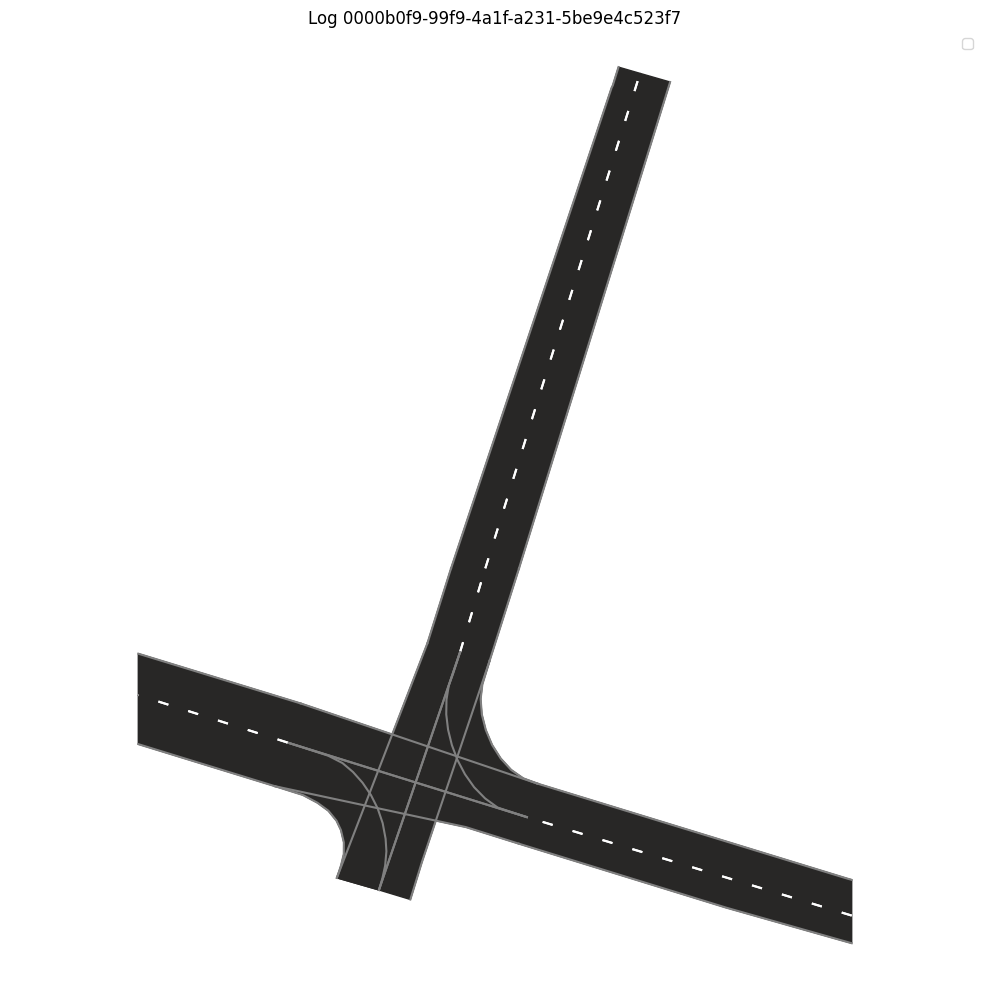

In [16]:
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)

query_center: NDArrayFloat = np.array([last_obs_x, last_obs_y])
search_radius = 25 # m
nearby_lane_segments = static_map.get_nearby_lane_segments(query_center,search_radius)
NUM_LANES = 100
nearby_lane_segments = nearby_lane_segments[:NUM_LANES]
plot_lane_segments(ax=ax, lane_segments=nearby_lane_segments) # Nearby lane segments

# plot_lane_segments(ax=ax, lane_segments=static_map.get_scenario_lane_segments()) # All lane segments

plt.axis("equal")
# plt.xlim(*xlims)
# plt.ylim(*ylims)
plt.title(f"Log {scenario_id}")
plt.axis("off")
plt.legend()
plt.tight_layout()

# plt.savefig(os.path.join(SAVE_DIR,"test_carlos_nearby.jpg"), dpi=500)

plt.show()
plt.close("all")

In [17]:
len(nearby_lane_segments)
nearby_lane_segments[0]
nearby_lane_segments

# static_map.get_scenario_vector_drivable_areas() # Get local map driveable areas

[LaneSegment(id=390753409, is_intersection=False, lane_type=<LaneType.VEHICLE: 'VEHICLE'>, right_lane_boundary=Polyline(waypoints=[Point(x=40.59, y=-340.58, z=5.56), Point(x=43.66, y=-330.38, z=5.54), Point(x=43.68, y=-330.33, z=5.54), Point(x=43.72, y=-330.2, z=5.54), Point(x=43.74, y=-330.12, z=5.54), Point(x=43.76, y=-330.06, z=5.54), Point(x=43.78, y=-330.0, z=5.53)]), left_lane_boundary=Polyline(waypoints=[Point(x=36.48, y=-339.44, z=5.01), Point(x=39.34, y=-330.37, z=5.07), Point(x=39.35, y=-330.33, z=5.07), Point(x=39.4, y=-330.2, z=5.07), Point(x=39.42, y=-330.11, z=5.08), Point(x=39.44, y=-330.05, z=5.08), Point(x=39.46, y=-330.0, z=5.15)]), right_mark_type=<LaneMarkType.DASHED_WHITE: 'DASHED_WHITE'>, left_mark_type=<LaneMarkType.NONE: 'NONE'>, predecessors=[390753606], successors=[390754196], right_neighbor_id=390753780, left_neighbor_id=None),
 LaneSegment(id=390753588, is_intersection=True, lane_type=<LaneType.VEHICLE: 'VEHICLE'>, right_lane_boundary=Polyline(waypoints=[Poi

In [18]:
from matplotlib.patches import Rectangle
from PIL import Image as img
from PIL.Image import Image
from typing import Final, List, Optional, Sequence, Set, Tuple

from av2.datasets.motion_forecasting.data_schema import ArgoverseScenario, ObjectType, TrackCategory

_PlotBounds = Tuple[float, float, float, float]

# Configure constants
_OBS_DURATION_TIMESTEPS: Final[int] = 50
_PRED_DURATION_TIMESTEPS: Final[int] = 60

_ESTIMATED_VEHICLE_LENGTH_M: Final[float] = 4.0
_ESTIMATED_VEHICLE_WIDTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_LENGTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_WIDTH_M: Final[float] = 0.7
_PLOT_BOUNDS_BUFFER_M: Final[float] = 30.0

_DRIVABLE_AREA_COLOR: Final[str] = "#7A7A7A"
_LANE_SEGMENT_COLOR: Final[str] = "#E0E0E0"

_DEFAULT_ACTOR_COLOR: Final[str] = "#D3E8EF"
_FOCAL_AGENT_COLOR: Final[str] = "#ECA25B"
_AV_COLOR: Final[str] = "#007672"
_BOUNDING_BOX_ZORDER: Final[int] = 100  # Ensure actor bounding boxes are plotted on top of all map elements

_STATIC_OBJECT_TYPES: Set[ObjectType] = {
    ObjectType.STATIC,
    ObjectType.BACKGROUND,
    ObjectType.CONSTRUCTION,
    ObjectType.RIDERLESS_BICYCLE,
}

import math

In [19]:
lane_segments = static_map.get_scenario_lane_segments()
len(lane_segments)
lane_segments[:5]

[LaneSegment(id=390752190, is_intersection=False, lane_type=<LaneType.VEHICLE: 'VEHICLE'>, right_lane_boundary=Polyline(waypoints=[Point(x=10.64, y=-447.77, z=1.52), Point(x=10.96, y=-446.72, z=1.57), Point(x=12.55, y=-441.33, z=1.88), Point(x=15.03, y=-433.68, z=2.5), Point(x=19.23, y=-420.33, z=3.16), Point(x=19.24, y=-420.3, z=3.14), Point(x=19.29, y=-420.15, z=3.15), Point(x=19.29, y=-420.13, z=3.15), Point(x=19.31, y=-420.08, z=3.17), Point(x=19.32, y=-420.04, z=3.17), Point(x=19.33, y=-420.0, z=3.21)]), left_lane_boundary=Polyline(waypoints=[Point(x=6.75, y=-446.58, z=1.48), Point(x=15.09, y=-420.33, z=3.07), Point(x=15.1, y=-420.3, z=3.07), Point(x=15.14, y=-420.16, z=3.07), Point(x=15.15, y=-420.13, z=3.07), Point(x=15.16, y=-420.08, z=3.07), Point(x=15.18, y=-420.04, z=3.07), Point(x=15.19, y=-420.0, z=3.09)]), right_mark_type=<LaneMarkType.NONE: 'NONE'>, left_mark_type=<LaneMarkType.DASHED_WHITE: 'DASHED_WHITE'>, predecessors=[390752826], successors=[390753792], right_neighbo

In [20]:
def _plot_static_map_elements(static_map: ArgoverseStaticMap, lane_segments: List = [], show_ped_xings: bool = False) -> None:
    """Plot all static map elements associated with an Argoverse scenario.

    Args:
        static_map: Static map containing elements to be plotted.
        show_ped_xings: Configures whether pedestrian crossings should be plotted.
    """
    # # Plot drivable areas
    # for drivable_area in static_map.vector_drivable_areas.values():
    #     _plot_polygons([drivable_area.xyz], alpha=0.5, color=_DRIVABLE_AREA_COLOR)

    # Plot lane segments
    
    if lane_segments:
        lane_segments_ = lane_segments
    else:
        lane_segments_ = static_map.vector_lane_segments.values()
        
    for lane_segment in lane_segments_:
        _plot_polylines(
            [
                lane_segment.left_lane_boundary.xyz,
                lane_segment.right_lane_boundary.xyz,
            ],
            line_width=0.5,
            color=_LANE_SEGMENT_COLOR,
        )

    # Plot pedestrian crossings
    if show_ped_xings:
        for ped_xing in static_map.vector_pedestrian_crossings.values():
            _plot_polylines([ped_xing.edge1.xyz, ped_xing.edge2.xyz], alpha=1.0, color=_LANE_SEGMENT_COLOR)


def _plot_actor_tracks(ax: plt.Axes, scenario: ArgoverseScenario, timestep: int) -> Optional[_PlotBounds]:
    """Plot all actor tracks (up to a particular time step) associated with an Argoverse scenario.

    Args:
        ax: Axes on which actor tracks should be plotted.
        scenario: Argoverse scenario for which to plot actor tracks.
        timestep: Tracks are plotted for all actor data up to the specified time step.

    Returns:
        track_bounds: (x_min, x_max, y_min, y_max) bounds for the extent of actor tracks.
    """
    track_bounds = None
    for track in scenario.tracks:
        # Get timesteps for which actor data is valid
        actor_timesteps: NDArrayInt = np.array(
            [object_state.timestep for object_state in track.object_states if object_state.timestep <= timestep]
        )
        if actor_timesteps.shape[0] < 1 or actor_timesteps[-1] != timestep:
            continue

        # Get actor trajectory and heading history
        actor_trajectory: NDArrayFloat = np.array(
            [list(object_state.position) for object_state in track.object_states if object_state.timestep <= timestep]
        )
        actor_headings: NDArrayFloat = np.array(
            [object_state.heading for object_state in track.object_states if object_state.timestep <= timestep]
        )

        # Plot polyline for focal agent location history
        track_color = _DEFAULT_ACTOR_COLOR
        if track.category == TrackCategory.FOCAL_TRACK:
            x_min, x_max = actor_trajectory[:, 0].min(), actor_trajectory[:, 0].max()
            y_min, y_max = actor_trajectory[:, 1].min(), actor_trajectory[:, 1].max()
            track_bounds = (x_min, x_max, y_min, y_max)
            track_color = _FOCAL_AGENT_COLOR
            _plot_polylines([actor_trajectory], color=track_color, line_width=2)
        elif track.track_id == "AV":
            track_color = _AV_COLOR
        elif track.object_type in _STATIC_OBJECT_TYPES:
            continue

        # Plot bounding boxes for all vehicles and cyclists
        if track.object_type == ObjectType.VEHICLE:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_VEHICLE_LENGTH_M, _ESTIMATED_VEHICLE_WIDTH_M),
            )
        elif track.object_type == ObjectType.CYCLIST or track.object_type == ObjectType.MOTORCYCLIST:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_CYCLIST_LENGTH_M, _ESTIMATED_CYCLIST_WIDTH_M),
            )
        else:
            plt.plot(actor_trajectory[-1, 0], actor_trajectory[-1, 1], "o", color=track_color, markersize=4)

    return track_bounds


def _plot_polylines(
    polylines: Sequence[NDArrayFloat],
    *,
    style: str = "-",
    line_width: float = 1.0,
    alpha: float = 1.0,
    color: str = "r",
) -> None:
    """Plot a group of polylines with the specified config.

    Args:
        polylines: Collection of (N, 2) polylines to plot.
        style: Style of the line to plot (e.g. `-` for solid, `--` for dashed)
        line_width: Desired width for the plotted lines.
        alpha: Desired alpha for the plotted lines.
        color: Desired color for the plotted lines.
    """
    for polyline in polylines:
        plt.plot(polyline[:, 0], polyline[:, 1], style, linewidth=line_width, color=color, alpha=alpha)


def _plot_polygons(polygons: Sequence[NDArrayFloat], *, alpha: float = 1.0, color: str = "r") -> None:
    """Plot a group of filled polygons with the specified config.

    Args:
        polygons: Collection of polygons specified by (N,2) arrays of vertices.
        alpha: Desired alpha for the polygon fill.
        color: Desired color for the polygon.
    """
    for polygon in polygons:
        plt.fill(polygon[:, 0], polygon[:, 1], color=color, alpha=alpha)


def _plot_actor_bounding_box(
    ax: plt.Axes, cur_location: NDArrayFloat, heading: float, color: str, bbox_size: Tuple[float, float]
) -> None:
    """Plot an actor bounding box centered on the actor's current location.

    Args:
        ax: Axes on which actor bounding box should be plotted.
        cur_location: Current location of the actor (2,).
        heading: Current heading of the actor (in radians).
        color: Desired color for the bounding box.
        bbox_size: Desired size for the bounding box (length, width).
    """
    (bbox_length, bbox_width) = bbox_size

    # Compute coordinate for pivot point of bounding box
    d = np.hypot(bbox_length, bbox_width)
    theta_2 = math.atan2(bbox_width, bbox_length)
    pivot_x = cur_location[0] - (d / 2) * math.cos(heading + theta_2)
    pivot_y = cur_location[1] - (d / 2) * math.sin(heading + theta_2)

    vehicle_bounding_box = Rectangle(
        (pivot_x, pivot_y), bbox_length, bbox_width, np.degrees(heading), color=color, zorder=_BOUNDING_BOX_ZORDER
    )
    ax.add_patch(vehicle_bounding_box)

/tmp/ipykernel_3414407/3878837940.py:152: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


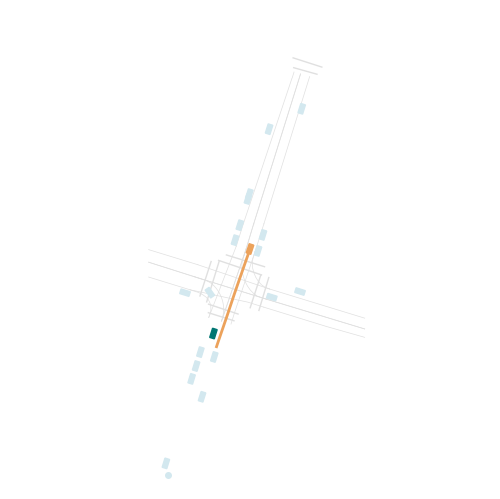

In [21]:
_, ax = plt.subplots()

timestep = 50
# Plot static map elements and actor tracks
# _plot_static_map_elements(static_map, show_ped_xings=True)
_plot_static_map_elements(static_map, lane_segments=nearby_lane_segments, show_ped_xings=True)
cur_plot_bounds = _plot_actor_tracks(ax, scenario, timestep)

if cur_plot_bounds:
    plot_bounds = cur_plot_bounds

# Set map bounds to capture focal trajectory history (with fixed buffer in all directions)
# plt.xlim(plot_bounds[0] - _PLOT_BOUNDS_BUFFER_M, plot_bounds[1] + _PLOT_BOUNDS_BUFFER_M)
# plt.ylim(plot_bounds[2] - _PLOT_BOUNDS_BUFFER_M, plot_bounds[3] + _PLOT_BOUNDS_BUFFER_M)
_PLOT_BOUNDS_BUFFER_M = 100
plt.xlim(last_obs_x - _PLOT_BOUNDS_BUFFER_M, last_obs_x + _PLOT_BOUNDS_BUFFER_M)
plt.ylim(last_obs_y - _PLOT_BOUNDS_BUFFER_M, last_obs_y + _PLOT_BOUNDS_BUFFER_M)
plt.gca().set_aspect("equal", adjustable="box")

# # Minimize plot margins and make axes invisible
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.show()
plt.close("all")

In [22]:
len(nearby_lane_segments)

14

In [16]:
from lane_segment import *

def get_mark_type(self, x, mark_type):
    # none = 0, single_line = 1, double_line =2; 
    # dash = 0, solid =1; 
    # dash = 0, solid =1; 
    # white =0, yellow = 1, blue = 2; 
    if mark_type == LaneMarkType.DASH_SOLID_YELLOW:
        x[:, 0] = 2
        x[:, 1] = 0
        x[:, 2] = 1
        x[:, 3] = 1
    elif mark_type == LaneMarkType.DASH_SOLID_WHITE:
        x[:, 0] = 2
        x[:, 1] = 0
        x[:, 2] = 1
        x[:, 3] = 0
    elif mark_type == LaneMarkType.DASHED_WHITE:   
        x[:, 0] = 1
        x[:, 1] = 0
        x[:, 2] = 0
        x[:, 3] = 0
    elif mark_type == LaneMarkType.DASHED_YELLOW:   
        x[:, 0] = 1
        x[:, 1] = 0
        x[:, 2] = 0  
        x[:, 3] = 1
    elif mark_type == LaneMarkType.DOUBLE_SOLID_YELLOW:
        x[:, 0] = 2
        x[:, 1] = 1
        x[:, 2] = 1
        x[:, 3] = 1
    elif mark_type == LaneMarkType.DOUBLE_SOLID_WHITE:   
        x[:, 0] = 2
        x[:, 1] = 1
        x[:, 2] = 1
        x[:, 3] = 0
    elif mark_type == LaneMarkType.DOUBLE_DASH_YELLOW:   
        x[:, 0] = 2
        x[:, 1] = 0
        x[:, 2] = 0  
        x[:, 3] = 1            
    elif mark_type == LaneMarkType.DOUBLE_DASH_WHITE:
        x[:, 0] = 2
        x[:, 1] = 0
        x[:, 2] = 0
        x[:, 3] = 0
    elif mark_type == LaneMarkType.SOLID_YELLOW:   
        x[:, 0] = 1
        x[:, 1] = 1
        x[:, 2] = 1
        x[:, 3] = 1
    elif mark_type == LaneMarkType.SOLID_WHITE:   
        x[:, 0] = 1
        x[:, 1] = 1
        x[:, 2] = 1  
        x[:, 3] = 0
    elif mark_type == LaneMarkType.SOLID_DASH_WHITE:
        x[:, 0] = 2
        x[:, 1] = 1
        x[:, 2] = 0
        x[:, 3] = 0
    elif mark_type == LaneMarkType.SOLID_DASH_YELLOW:   
        x[:, 0] = 2
        x[:, 1] = 1
        x[:, 2] = 0
        x[:, 3] = 1
    elif mark_type == LaneMarkType.SOLID_BLUE:   
        x[:, 0] = 1
        x[:, 1] = 1
        x[:, 2] = 1  
        x[:, 3] = 2 
    elif mark_type == LaneMarkType.UNKNOWN:
        x[:, 0] = 1
        x[:, 1] = 0
        x[:, 2] = 0  
        x[:, 3] = 0 
    elif mark_type == LaneMarkType.NONE:   
        x[:, 0] = 0
        x[:, 1] = 0
        x[:, 2] = 0  
        x[:, 3] = 0 
    return x

ModuleNotFoundError: No module named 'lane_segment'